# Анализ рынка видеоигр для составления рекламной компании на 2017 год

## Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

## Первичный анализ данных

In [2]:
try:
    df_games = pd.read_csv("games.csv")
except:
    df_games = pd.read_csv("/datasets/games.csv")

In [3]:
print('Размеры датафрейма', df_games.shape)
df_games.info()
df_games.head()

Размеры датафрейма (16715, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В исследуемом dataframe 16715 строк и 11 столбцов, сразу видно наличие пропусков, также некорректен формат у некоторых столбцов.

## Предобработка данных

Переведём названия столбцов в snake_case

In [4]:
df_games.columns = df_games.columns.str.lower()

Видно, что тип столбца user_score не соответствует действительности переведём его во float

In [5]:
df_games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
9.6       2
0.6       2
0.3       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Видим tbd:To Be Determined – английскую аббревиатуру, которая означает «будет определено», заменим её на NaN и изменим тип колонки.

In [6]:
df_games['user_score'].replace('tbd', None, inplace=True)
df_games['user_score'] = pd.to_numeric(df_games['user_score'])

Теперь рассмотри наличие пропусков в данных

In [7]:
df_games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         7955
rating             6766
dtype: int64

Пропусков в жанре и названии по 2, посмотрим эти строки возможно они совпадают

In [8]:
df_games[df_games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


2 игры по которым практически нет информации, думаю их можно удалить.

In [9]:
df_games = df_games.dropna(subset=['name'])
df_games.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         7953
rating             6764
dtype: int64

В столбце с годом релиза всего 269 пропусков, что тоже достаточно мало относительно почти 17000 строк, поэтому можно их удалить

In [10]:
df_games = df_games.dropna(subset=['year_of_release'])
df_games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         7835
rating             6676
dtype: int64

Так как пропуски удалили,то можем поменять тип столбца year_of_release на int.

In [11]:
df_games['year_of_release'] = df_games['year_of_release'].astype(int)

Посмотрим процент пропусков в оставшихся столбцах

In [12]:
df_games.isna().mean() * 100

name                0.000000
platform            0.000000
year_of_release     0.000000
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.453418
user_score         47.646558
rating             40.598395
dtype: float64

51%, 54%, 40% - слишком большие значения чтобы просто удалить пропуски

Столбец rating - категориальная переменная строкового типа, так что заполним строкой NaN означающей отсутствие значения.

In [13]:
df_games['rating'] = df_games['rating'].fillna('Nan')

Способов как логично заполнить столбцы с оценками пользователей и критиков я не вижу, а так как их больше 50% то заполнение медианой сильно нарушит картину, поэтому просто оставим их.

Переведём все строки в lowercase

In [14]:
str_rows = ['name', 'genre', 'platform']
df_games[str_rows] = df_games[str_rows].applymap(str.lower)

Посмотрим количество явных дубликатов

In [15]:
df_games.duplicated().sum()

0

Попробуем найти неявные дубликаты - игры с одним названием, платформой и годом выпуска.

In [16]:
df_games.duplicated(subset=['name', 'platform', 'year_of_release']).sum()

1

Всего 2, удалим их.

In [17]:
df_games = df_games.drop_duplicates(subset=['name', 'platform', 'year_of_release'])

Создадим отдельный столбец с суммарными продажами по всем регионами.

In [18]:
df_games['sales'] = df_games[['eu_sales', 'na_sales', 'jp_sales', 'other_sales']].sum(axis=1)

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> 
    
Еще тут можно использовать метод `DataFrame.sum` с аргументом `axis=1`</div>

```python

        df['total_sum'] = df[['value_1', 'value_2', 'value_3', 'value_4']].sum(axis=1)
    
```

### Промежуточный вывод по предобработке
В ходе предобработки были поменяны некоторые строковые значение, изменён тип 1 столбца, проведена работа с пропусками и дубликатами и добавлен новый столбец. 
* Изменили тип столбца user_rating на числовой и year_of_release на целочисленный.
* Перевели все названия столбцов в snake_case, а все строковые значения в lower_case. 
* Удалили строки с пропусками в столбцах name, genre, year_of_release, а в столбце rating заменили на строку Nan означающую отсутсвие данных.
* Проверили наличие явных и неявных дубликатов и удалили все найденные
* Добавили новый столбец sales с суммарной вырочкой по миру.


## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы

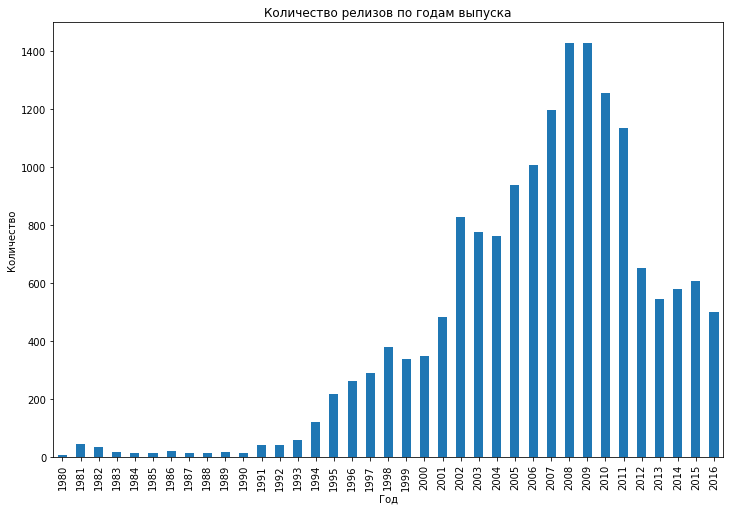

In [19]:
plt.figure(figsize=(12,8))
df_games['year_of_release'].value_counts().sort_index().plot(kind='bar')
plt.title('Количество релизов по годам выпуска')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

До 1995 игр почти не выпускалось, пик по количеству игр был достигнут в 2008, 2009 и к 2016 году происходит снижение.

Посмотрим, как с годами менялись продажи по платформам. Для анализа возьмём лишь 25% платформ с наибольшим количеством продаж.

In [20]:
platform_sales = df_games.groupby(by='platform')['sales'].sum()
# Выбираем топ 25% платформ
platform_sales = platform_sales[platform_sales > platform_sales.quantile(0.75)]
top_platforms = platform_sales.index.values
# Оставляем в датафрейме только выбранные платформы
df_games_platform_top = df_games.query('platform in @top_platforms')

In [21]:
platform_cross_year = df_games_platform_top.pivot_table(index='platform', columns='year_of_release', values='sales', aggfunc='sum')
platform_cross_year

year_of_release,1985,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
ds,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
gba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,61.53,74.16,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ps,NaN,6.03,35.96,94.7,136.17,169.49,144.53,96.37,35.59,6.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ps2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.17,166.43,205.38,...,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN
ps3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.19,118.52,130.93,142.17,156.78,107.35,113.25,47.76,16.82,3.60
ps4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25
wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
x360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52


Text(0.5, 51.0, 'Год')

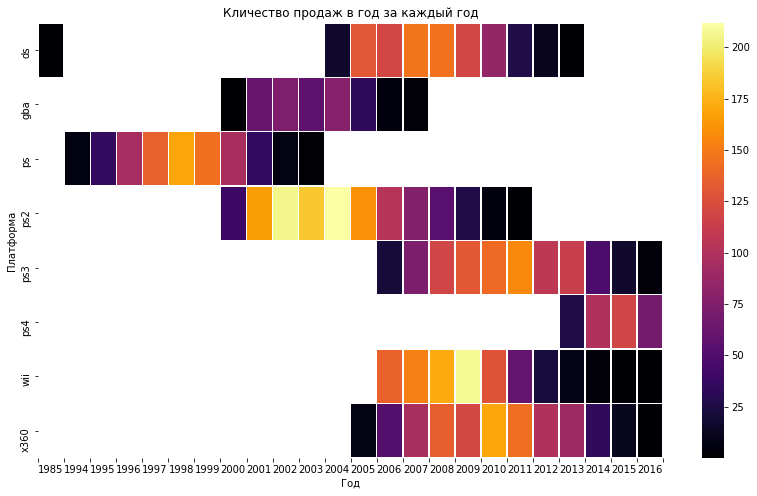

In [22]:
plt.figure(figsize=(14,8))
# построим сводную таблицу с продажами по каждой платформе за каждый год
platform_cross_year = df_games_platform_top.pivot_table(index='platform', columns='year_of_release', values='sales', aggfunc='sum')
# Строим heatmap
sns.heatmap(platform_cross_year, cmap='inferno', linewidths=.5)
# Добавляем показ столбцов
plt.xticks(ticks=range(platform_cross_year.shape[1] + 1), labels=list(platform_cross_year.columns) + [''], ha='left')
plt.title('Кличество продаж в год за каждый год')
plt.ylabel('Платформа')
plt.xlabel('Год')

Видим, что для большинства платформ график показывает в среднем промежуток активности от 9-11 лет, причём все рассмотренные платформы кроме ps4 к 2016 году либо уже умерли, либо заканчивают свой путь.

Оценим примерный срок жизни для всех платформ.

In [23]:
# построим сводную таблицу с продажами по каждой платформе за каждый год
platform_year_sales = df_games.pivot_table(index='platform', columns='year_of_release', values='sales', aggfunc='sum')
# добавим столбец со сроком продаж
platform_year_sales['sales_period'] = platform_year_sales.apply(lambda row: row.last_valid_index() - row.first_valid_index(), axis=1)
# так как значений мало и есть как минимум 1 очент выбивающееся значение - pc, то находим медиану
avg_life_period = platform_year_sales['sales_period'].median()
print("Средний срок жизни одной платформы", avg_life_period, "лет")

Средний срок жизни одной платформы 6.0 лет


Так как нам нужен не весь жизненный период платформы, а только его активная часть, то возьмём половину от посчитанного значения, а именно 3 года.

In [24]:
actual_period = avg_life_period / 2 

Создадим новый dataframe с данными за актуальный период.

In [25]:
research_year = 2017
start_year = research_year - actual_period 
df_games_actual = df_games[df_games['year_of_release'] >= start_year]
df_games_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       925 non-null    float64
 10  rating           1689 non-null   object 
 11  sales            1689 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 171.5+ KB


In [26]:
df_games_actual['platform'].value_counts()

ps4     376
psv     295
xone    228
ps3     219
3ds     212
pc      151
x360    111
wiiu     73
psp      13
wii      11
Name: platform, dtype: int64

Всего 11 игр на wii и 13 на psp, думаю их стоит удалить.

In [27]:
df_games_actual = df_games_actual.query('platform != "wii" and platform !="psp"')

In [28]:
df_games_actual['platform'].value_counts()

ps4     376
psv     295
xone    228
ps3     219
3ds     212
pc      151
x360    111
wiiu     73
Name: platform, dtype: int64

In [29]:
sales_from_start_year = df_games_actual.pivot_table(index='year_of_release', values='sales', aggfunc='sum')
sales_from_start_year

,sales
year_of_release,
2014,327.54
2015,266.72
2016,129.76


С 2011 года абсолютные продажи стабильно падают, так что есть смысл смотреть на продажи относительные

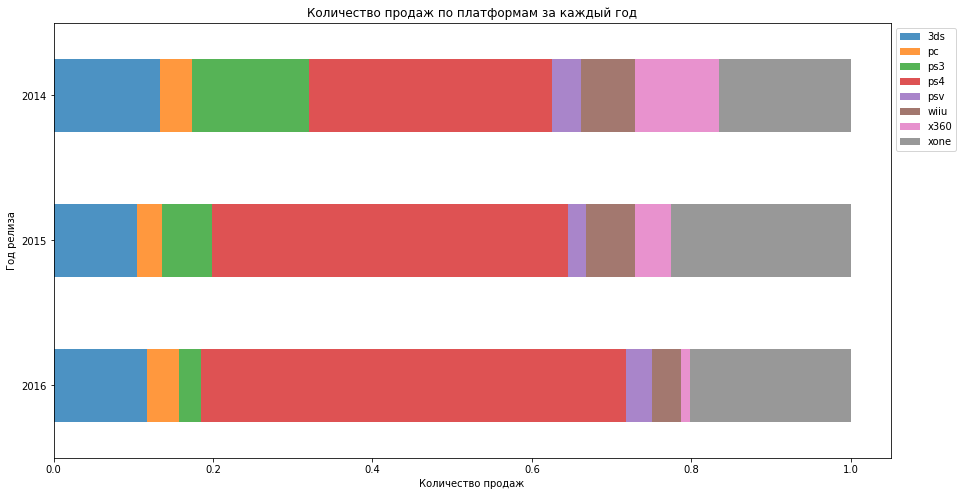

In [30]:
# создадим сводную по годам и платформам:
platform_cross_year_actual = pd.crosstab(index=df_games_actual['year_of_release'], columns=df_games_actual['platform'], values=df_games_actual['sales'], aggfunc='sum').sort_index(ascending=False)
# Нормализуем данные чтоб сумма в каждой строке была 1
platform_cross_year_actual_norm = platform_cross_year_actual.div(platform_cross_year_actual.sum(1), axis=0)
# создадим гистограмму с накоплением
platform_cross_year_actual_norm.plot.barh(stacked=True, alpha=0.8, figsize=(15, 8))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Количество продаж по платформам за каждый год')
plt.ylabel('Год релиза')
plt.xlabel('Количество продаж');

Видим, что к 2016 году осталось 8 платформ. Доли xone и ps4 на рынке стабильно растут, доли остальных либо малы, либо падают, либо остаются неизменными. Тогда в качестве потенциально выгодных платформ предлагается выбрать ps4, xone

Рассмотрим глобальные продажи для всех платформ

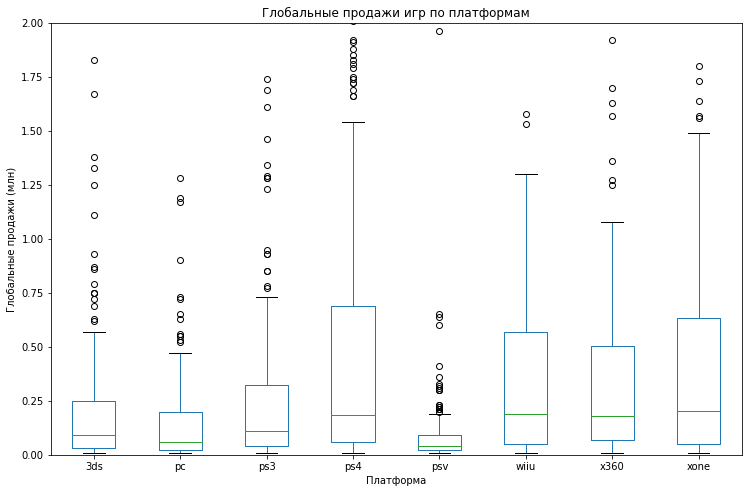

In [31]:

df_games_actual.boxplot(by='platform', column='sales', grid=False, figsize=(12,8))
plt.title('Глобальные продажи игр по платформам')
plt.suptitle('')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн)')
plt.ylim(0, 2)
plt.show()

В целом достаточно много значений выбивается за 1.5 межквартильных размаха. Скорее в основном выбросами являются релизы крупных студий, так как их не очень много в год, то они почти никак не влияют на квартили. Почти для всех платформ медина до 250000 тыс. копий, при этом минимальная у psp и psv, максимальная у x360. Но очень сильно отличаются 3 квартили, далеко вверх относительно остальных уходят у ps3, ps4, x360, xone

Рассмотрим влияние оценок критиков и пользователей на продажи, для этого напишем функцию которая строит графики зависимости и выводит коофициенты корреляции.

In [32]:
def score_influence(df_games_actual, platform):
    fig, axs = plt.subplots(1, 2, figsize=(17, 5))
# Строим графики зависимости продаж от user_score и critic_score   
    for i, score_type in enumerate(['user_score', 'critic_score']):
        axs[i].scatter(x=score_type, y='sales', data=df_games_actual[df_games_actual['platform'] == platform])
        axs[i].set_title(f'Зависимость продаж от {score_type} для {platform}')
        axs[i].set_xlabel(f'{score_type.capitalize()}')
        axs[i].set_ylabel('Количество продаж млн')
        axs[i].set_ylim(0, 2)
    plt.tight_layout()
    plt.show()
# Выводим коофициенты корреляции 
    df_games_actual_platform = df_games_actual[df_games_actual['platform'] == platform]
    print(f"Корреляция между оценкой пользователя и количеством продаж для {platform} = ",
          df_games_actual_platform['user_score'].corr(df_games_actual_platform['sales']))
    print(f"Корреляция между оценкой критиков и количеством продаж для {platform} = ",
          df_games_actual_platform['critic_score'].corr(df_games_actual_platform['sales']))

Посмотрим на зависимости для всех столбцов

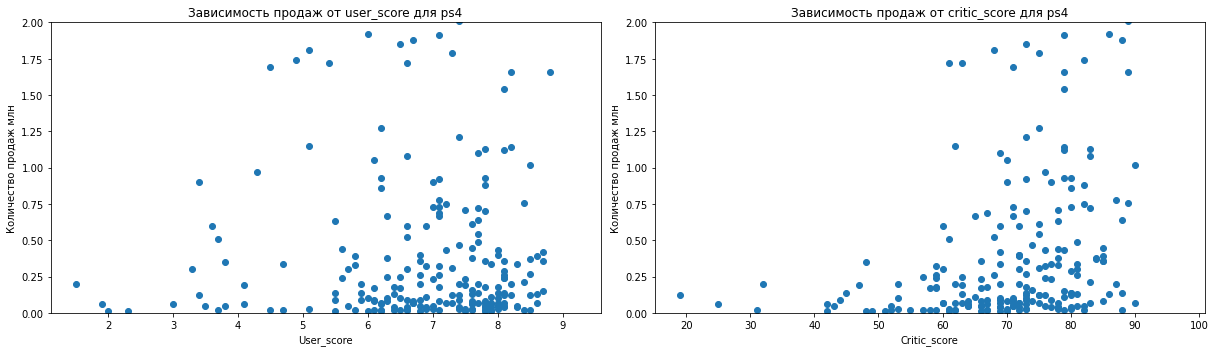

Корреляция между оценкой пользователя и количеством продаж для ps4 =  -0.03501047705575576
Корреляция между оценкой критиков и количеством продаж для ps4 =  0.40266141068104083


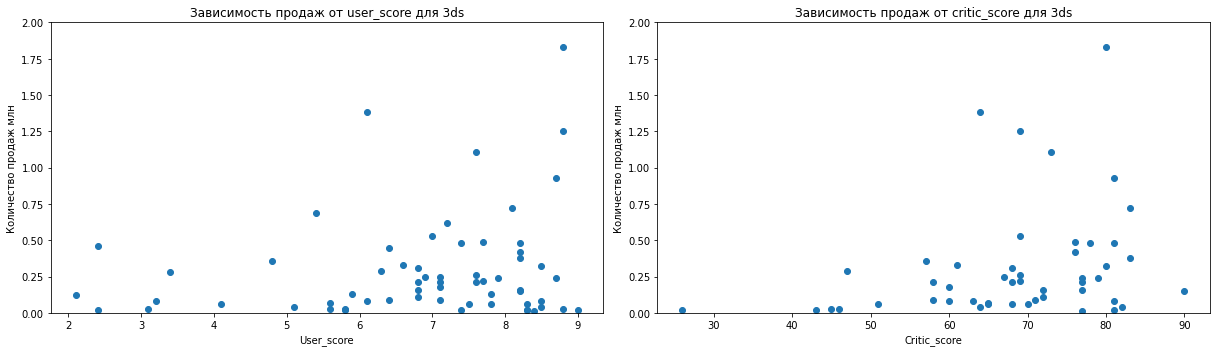

Корреляция между оценкой пользователя и количеством продаж для 3ds =  0.23422305769017177
Корреляция между оценкой критиков и количеством продаж для 3ds =  0.314117492869051


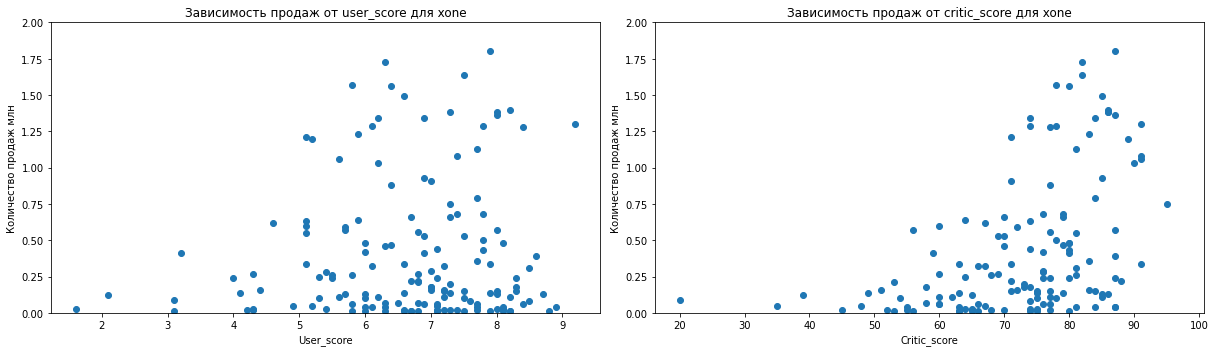

Корреляция между оценкой пользователя и количеством продаж для xone =  -0.07146551179048775
Корреляция между оценкой критиков и количеством продаж для xone =  0.42867694370333226


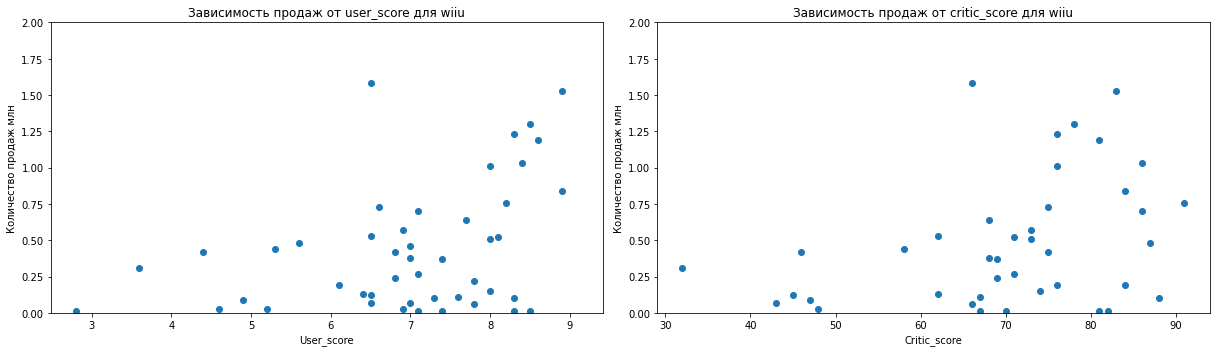

Корреляция между оценкой пользователя и количеством продаж для wiiu =  0.40521328521824995
Корреляция между оценкой критиков и количеством продаж для wiiu =  0.370201412480884


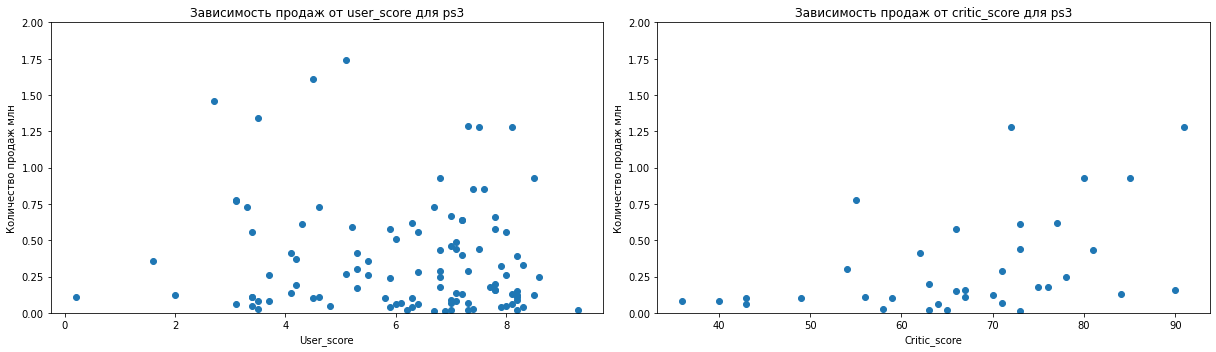

Корреляция между оценкой пользователя и количеством продаж для ps3 =  -0.18652243705959468
Корреляция между оценкой критиков и количеством продаж для ps3 =  0.44657460493190704


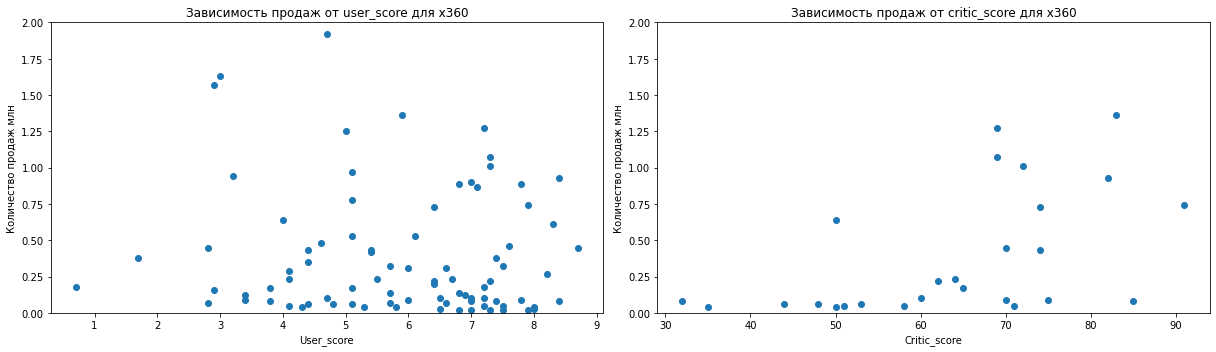

Корреляция между оценкой пользователя и количеством продаж для x360 =  -0.14052931639059543
Корреляция между оценкой критиков и количеством продаж для x360 =  0.5257228356581523


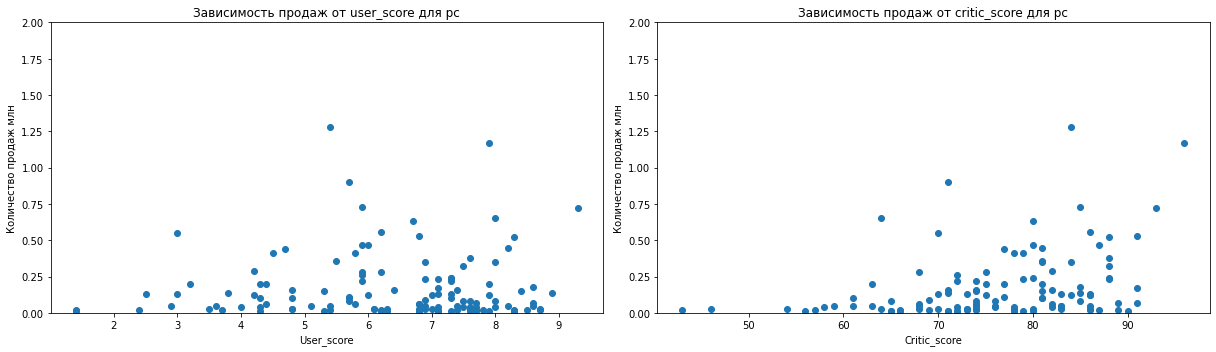

Корреляция между оценкой пользователя и количеством продаж для pc =  -0.07628975922388147
Корреляция между оценкой критиков и количеством продаж для pc =  0.17463413769350036


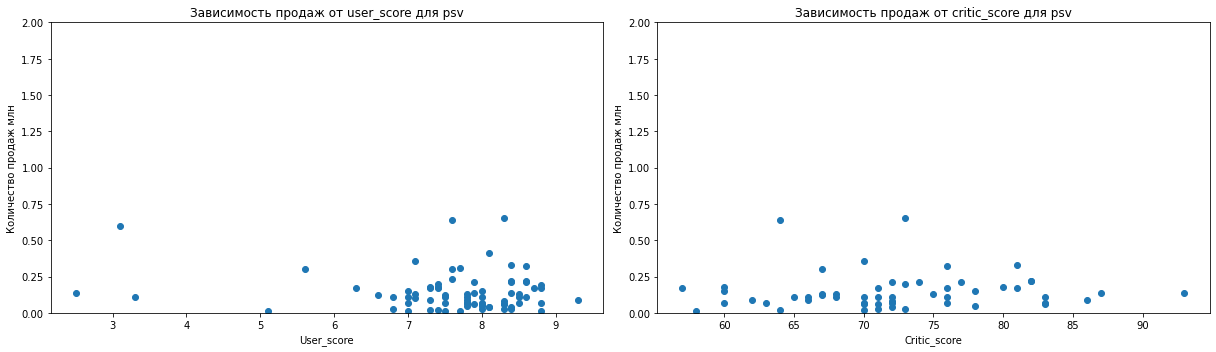

Корреляция между оценкой пользователя и количеством продаж для psv =  -0.14172235729666688
Корреляция между оценкой критиков и количеством продаж для psv =  0.04266490657009526


In [33]:
for platform in df_games_actual['platform'].unique():
    score_influence(df_games_actual, platform)
    

In [34]:
print("Корреляция между оценкой пользователя и количеством продаж для = ",
          df_games_actual['user_score'].corr(df_games_actual['sales']))
print("Корреляция между оценкой критиков и количеством продаж = ",
          df_games_actual['critic_score'].corr(df_games_actual['sales']))

Корреляция между оценкой пользователя и количеством продаж для =  -0.012407173160195364
Корреляция между оценкой критиков и количеством продаж =  0.328105086966363


В целом видно, что в большинстве случаев корреляция между оценкой критиков и продажами - умеренная, пользовательские оценки же линейно практически никак не влияют. Это можно объяснить что данные получены с тех лет, когда интернет сообщества не были так распространены и критики, которые имеют широкий охват и оцениваю игру ещё до начала продаж имеют какое-никакое влияние, а обычный пользователь не может донести свою мысль до остальных.

Попробуем выделить самый выгодный жанр, для этого рассмотрим медианные значения продаж по каждому жанру.

In [35]:
# Подсчёт медиан по каждому жанру
median_games_actual_genres = df_games_actual.groupby(by='genre')['sales'].median().sort_values(ascending=False)
median_games_actual_genres

genre
shooter         0.515
sports          0.180
platform        0.140
fighting        0.125
role-playing    0.110
simulation      0.100
action          0.090
misc            0.090
racing          0.090
strategy        0.060
puzzle          0.045
adventure       0.030
Name: sales, dtype: float64

Text(0.5, 0, 'Жанр')

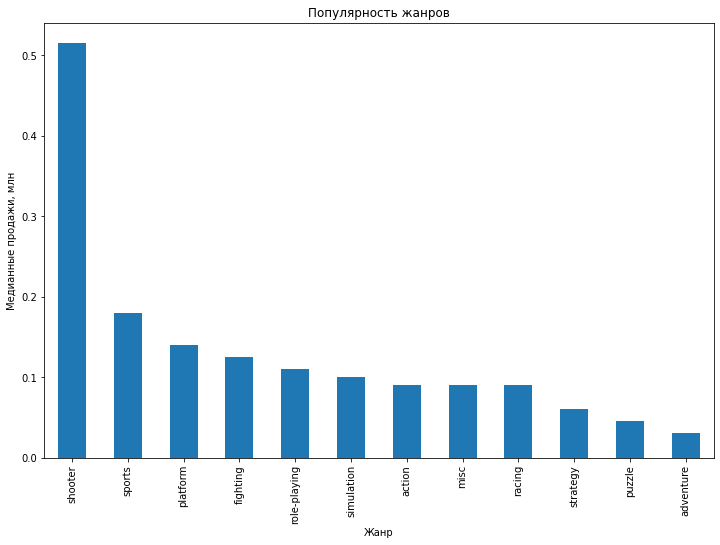

In [36]:
plt.figure(figsize=(12, 8))
median_games_actual_genres.plot(kind='bar')
plt.title('Популярность жанров')
plt.ylabel('Медианные продажи, млн')
plt.xlabel('Жанр')

Видно, что игры жанра shooter сильно популярнее всех остальных. Жанры adventure, strategy и puzzle продаются значительно хуже остальных.

### Промежуточный вывод по исследовательскому анализу

В ходе исследовательского анализа было выяснено следующее:
* Пик по количеству релизов в год был достигнут в 2008 - 2009.
* Для большинства платформ жизненного цикл составляет 6 лет. Так как мы анализируем характеристики важные для 2017 года, то возьмём для дальнейшего анализа промежуток в половину полного жизненного цикла, а именно 3 года - 2014-2016.
* С 2011 года абсолютные продажи в мире стабильно падают.
* К 2016 году в наших данных активными осталось 8 платформ. Доли xone и ps4 на рынке стабильно растут, доли остальных либо малы, либо падают, либо остаются неизменными. В качестве потенциально выгодных платформ для 2017 года предлагается выбрать ps4, xone.
* В большинстве случаев корреляция между оценкой критиков и продажами - умеренная, пользовательские оценки же линейно практически никак не влияют.
* Жанр shooter наиболее популярен с большим отрывом. Жанры strategy, adventure и puzzle продаются значительно хуже остальных.

## Составление портрета пользователя каждого региона (NA, EU, JP)

In [37]:
import matplotlib.pyplot as plt

def make_portret_by(df_games_actual, index):
    # Строим сводную таблицу с суммой продаж в каждом регионе по всем платформам
    pivot_table_region_sales = df_games_actual.pivot_table(index=index,
                                          values=['eu_sales', 'na_sales', 'jp_sales'],
                                          aggfunc='sum')
    fig, axs = plt.subplots(1, 3, figsize=(19, 7))
    # Цикл по всем регионам
    for i, region in enumerate(['eu_sales', 'na_sales', 'jp_sales']):
        # Получаем 5 платформ с наибольшим количеством продаж
        top_platforms = pivot_table_region_sales[region].nlargest(5)
        # Строим круговую диаграмму с метками для каждой платформы
        axs[i].pie(top_platforms, labels=top_platforms.index, autopct="%1.1f%%")
        axs[i].legend(bbox_to_anchor=(1, 1))
        axs[i].set_title(region[:2].upper())
    fig.suptitle(f'Доля продаж по {index} в каждом регионе')
    plt.tight_layout()
    plt.show()

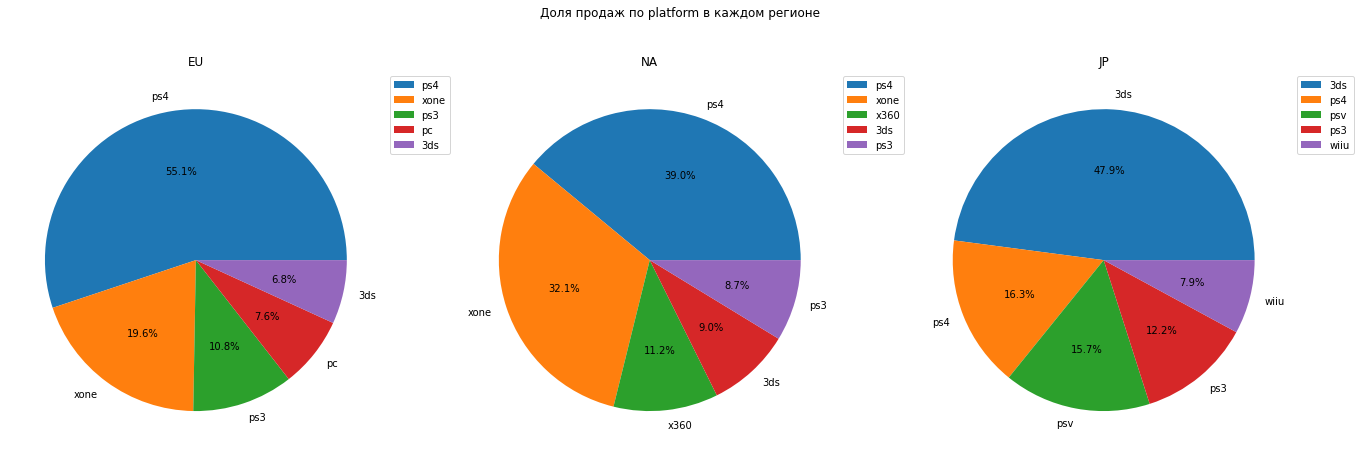

In [38]:
make_portret_by(df_games_actual, 'platform')

* В Европе большую часть рынка заняла ps4-55%, значительная доля у xone-20%, меньшую же долю занимают ps3, pc, 3ds(11%, 7%, 7%)
* В Америке больше половины рынка заняли ps4 и xone (39%, 32%), другую половину разделили между собой x360 -11%, p3ds-9%, ps3-19%
* В Японии  почти половину рынка заняла платформа 3ds - 48%, вторая половина поделена за ps4 - 16%, psv-16%, ps3-12%, wiiu-8%

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>

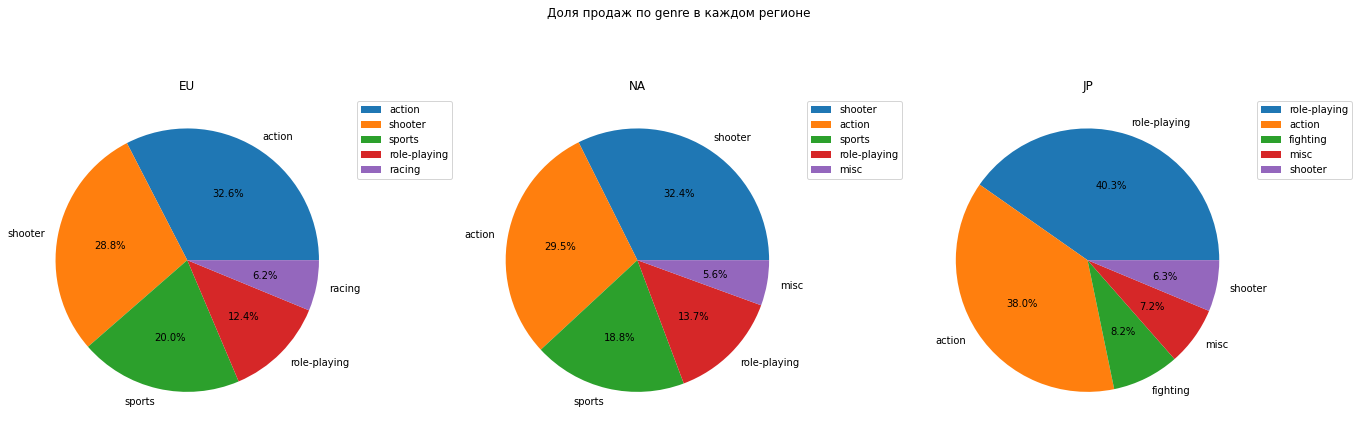

In [39]:
make_portret_by(df_games_actual, 'genre')

* В Европе более трети рыка заняли игры жанра action - 32%, большая часть рынка ещё за жанром shooter - 29%, остальная часть приходятся на жанры sports - 20%, role-playing - 12%, racing - 6%.
* В Америке ситуация очень похожа на Европу, треть за shooter - 32%, почти треть у жанра action - 30%, остальная часть приходятся на жанры sports - 19%, role-playing - 14%, misc - 15%.
* В Японии почти половина за role-playing - 41%, треть у жанра action - 38%, остальная часть приходятся на жанры fighting - 8%, misc - 7%, shooter - 6%.

Видим, что за рассматриваемый промежуток наибольшая доля продаж у жанра action.

Проверим влияет ли рейтинг ESRB на продажи в отдельном регионе

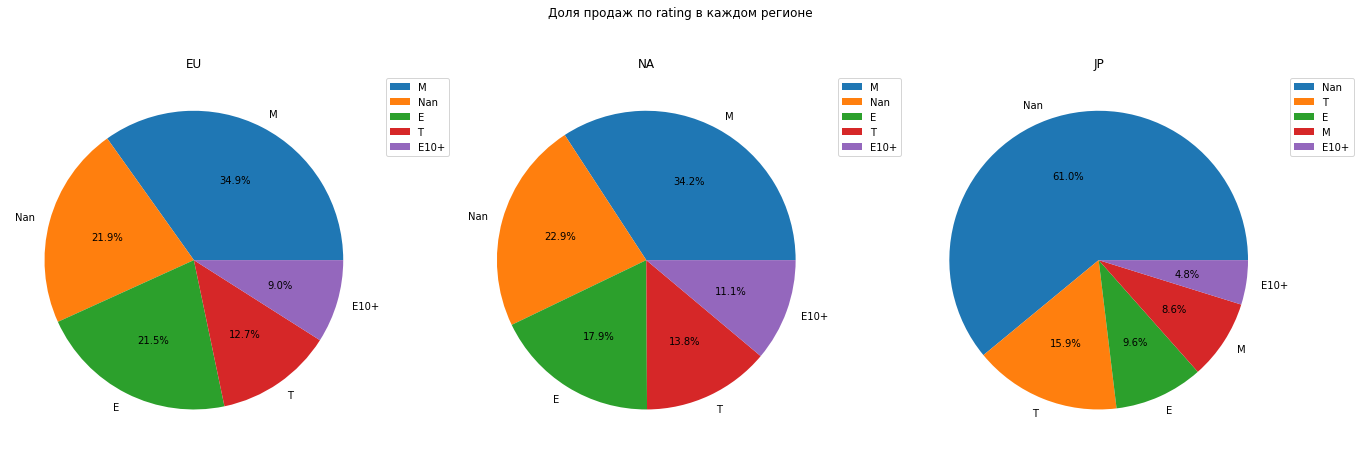

In [40]:
make_portret_by(df_games_actual, 'rating')

Видим, что графики долей у Европы и Америки очень похожи, при этом в Японии совсем другая ситуация - 61% пропусков против примерно 22% у eu и na и другой рейтинг популярности по возрастным ограничениям.

### Промежуточный вывод по портрету игрока в регионе
В целом в топ-5 по всем регионам входят одни и те же платформы и игры, а именно:
* Платформы: 3ds, ds, pc, ps3, ps4.
* Жанры: action, adventure, fighting, misc, platform.

По отдельным регионам такая ситуация:
* В Европе больше всего используются платформы 3ds, ds, pc(30%, 26%, 22%) и игры жанра action - 37% и adventure - 27%
* В Америке половину рынка заняли платформы 3ds, ds (33%, 25%) и наиболее популярны жанры игр action - 34%,adventure - 28%
* В Японии большую почти половину рынка заняла платформа 3ds - 48%, значительная часть за ds - 23%, почти половина игр жанра action - 43% и треть у жанра adventure - 34%. Также стоит обратить внимание, что игры рейтинга t имеют огромную популярность.




## Проверка гипотез
Для всех гипотез выберем уровень значимости alpha = 0.05



In [41]:
alpha = 0.05

Проверим, одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC.
* Нулевая гипотеза H0 - средние пользовательские рейтинги платформ Xbox One и PC равны
* Альтернативная гипотеза H1 - средние пользовательские рейтинги платформ Xbox One и PC не равны

Для проверки воспользуемся двусторонним t тестом для независимых выборок.

In [42]:
df_games_actual_pc = df_games_actual[df_games_actual['platform'] == 'pc']
df_games_actual_xone = df_games_actual[df_games_actual['platform'] == 'xone']
result = st.ttest_ind(df_games_actual_pc['user_score'], df_games_actual_xone['user_score'], nan_policy='omit')
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую  гипотезу') 

p-значение: 0.11827898819674322
Не получилось отвергнуть нулевую  гипотезу


<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> Круто, что используешь параметр nan_policy вместо удаления или фильтрации пропусков!</div>

С большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий

Проверим, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
* Нулевая гипотеза H0 - средние пользовательские рейтинги жанров Action и Sports равны
* Альтернативная гипотеза H1 - средние пользовательские рейтинги жанров Action и Sports не равны

Для проверки воспользуемся двусторонним t тестом для независимых выборок.

In [43]:
df_games_actual_action = df_games_actual[df_games_actual['genre'] == 'action']
df_games_actual_sports = df_games_actual[df_games_actual['genre'] == 'sports']
result = st.ttest_ind(df_games_actual_action['user_score'], df_games_actual_sports['user_score'], nan_policy='omit')
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось нулевую отвергнуть гипотезу') 

p-значение: 2.754437923035065e-17
Отвергаем нулевую гипотезу


Можем с уверенностью сказать, что средние рейтинги этих жанров отличаются

### Промежуточный вывод по проверке гипотез
Мы проверили 2 гипотезы и получили следующие результаты
* Нельзя сказать, что средние пользовательские рейтинги у Xbox One и PC разные
* Можем с уверенностью сказать, что средние рейтинги жанров action и sports отличаются

## Общий вывод
В ходе работы с целью изучения характеристик влияющих на продажи игр была проведена предобработка данных, исследовательский анализ, составлен портрет пользователя для каждого региона и проверены несколько гипотез.

* В ходе предобработки было сделано следующее:
    * Изменили тип столбца user_rating на числовой и year_of_release на целочисленный.
    * Перевели все названия столбцов в snake_case, а все строковые значения в lower_case. 
    * Удалили строки с пропусками в столбцах name, genre, year_of_release, а в столбце rating заменили на строку Nan означающую отсутсвие данных.
    * Проверили наличие явных и неявных дубликатов и удалили все найденные
    * Добавили новый столбец sales с суммарной вырочкой по миру.

* В ходе исследовательского анализа было выяснено следующее:
    * Пик по количеству релизов в год был достигнут в 2008 - 2009.
    * Для большинства платформ жизненного цикл составляет 6 лет. Так как мы анализируем характеристики важные для 2017 года, то возьмём для дальнейшего анализа промежуток в половину полного жизненного цикла, а именно 3 года - 2014-2016.
    * С 2011 года абсолютные продажи в мире стабильно падают.
    * К 2016 году в наших данных активными осталось 8 платформ. Доли xone и ps4 на рынке стабильно растут, доли остальных либо малы, либо падают, либо остаются неизменными. В качестве потенциально выгодных платформ для 2017 года предлагается выбрать ps4, xone.
    * В большинстве случаев корреляция между оценкой критиков и продажами - умеренная, пользовательские оценки же линейно практически никак не влияют.
    * Жанр shooter наиболее популярен с большим отрывом. Жанры strategy, adventure и puzzle продаются значительно хуже остальных.

* По отдельным регионам ситуация такова:
    * В Европе больше всего используются платформы ps4 и xone(55%, 20%) и игры жанра action - 32% и shooter - 29%
    * В Америке половину рынка заняли платформы ps4 и xone (39%, 32%) и наиболее популярны жанры игр shooter - 32%, action - 30%
    * В Японии большую почти половину рынка заняла платформа 3ds - 48%, почти половина игр жанра role-playing - 41% и треть у жанра action - 38%.

* Мы проверили 2 гипотезы и получили следующие результаты
    * С большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий.
    * Можем с уверенностью сказать, что средние рейтинги жанров action и sports отличаются.

В целом было выяснено, что на продажи игр влияют оценки критиков, жанр и платформа на которой эта игра выпускается.
 Для всех регионов за последние годы большинство игр вышло на 3ds, но желательно обратить внимание на платформы ps4 и xone, так как они единственные из изученных со стабильно растущими продажами за последние 3 года, причём они не прошли даже половины своего жизненного цикла. Наиболее выгоден для широкой аудитории жанр action - он популярен по всему мире. 